In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import pickle
import gensim
import pyLDAvis.gensim
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import wordnet as wn
from gensim import corpora

nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marcus/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/marcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

# Feedback Analysis

In [4]:
feedback_df = pd.read_csv('Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [5]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

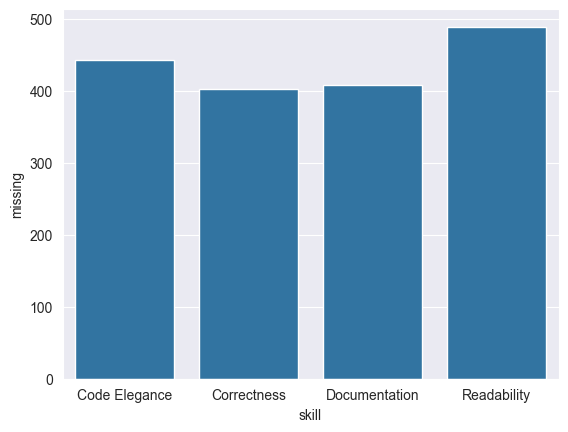

In [6]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### All unique feedback

In [7]:
unique_feedback_df = feedback_df[['skill', 'comments']]
unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()
unique_feedback_df = unique_feedback_df.groupby('skill').value_counts().reset_index()
unique_feedback_df.to_csv('data/unique_feedback.csv', index=False)
unique_feedback_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_70373/389625499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_feedback_df['comments'] = unique_feedback_df['comments'].str.lower()


,skill,comments,count
0,Code Elegance,"effective use of object-oriented principles, e...",38
1,Code Elegance,"methods are reusable and readable, but some co...",13
2,Code Elegance,the design could have been better.,13
3,Code Elegance,"it is good, though there are little problems h...",11
4,Code Elegance,solid implementation of both core and challeng...,11
...,...,...,...
1844,Readability,"very well written, code is simple and well mai...",1
1845,Readability,well structure and easy to read,1
1846,Readability,"well structured, code is easy to read",1
1847,Readability,with clear variable names and straightforward ...,1


https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a

### NLP Techniques

In [8]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [9]:
stopwords = nltk.corpus.stopwords.words('english')

def process_comments(comments):
    comments = comments.lower()
    comments = comments.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    tokens = nltk.word_tokenize(comments)
    
    tokens = [w for w in tokens if w not in stopwords]

    return tokens

In [10]:
nlp_df['tokens'] = nlp_df['comments'].apply(process_comments)
nlp_df['bigrams'] = nlp_df['tokens'].apply(lambda l: list(nltk.bigrams(l)))
nlp_df['trigrams'] = nlp_df['tokens'].apply(lambda l: list(nltk.ngrams(l, 3)))
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,bigrams,trigrams
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...","[(code, use), (use, meaningful), (meaningful, ...","[(code, use, meaningful), (use, meaningful, id..."
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, lo..."
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, co..."
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re..."
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re..."
...,...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...","[(implementation, good), (good, distinguishabl...","[(implementation, good, distinguishable), (goo..."
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]","[(compiling, specific), (specific, musicplayer...","[(compiling, specific, musicplayer), (specific..."
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...","[(comments, redundant), (redundant, state), (s...","[(comments, redundant, state), (redundant, sta..."
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...","[(methods, lack), (lack, detailed), (detailed,...","[(methods, lack, detailed), (lack, detailed, c..."


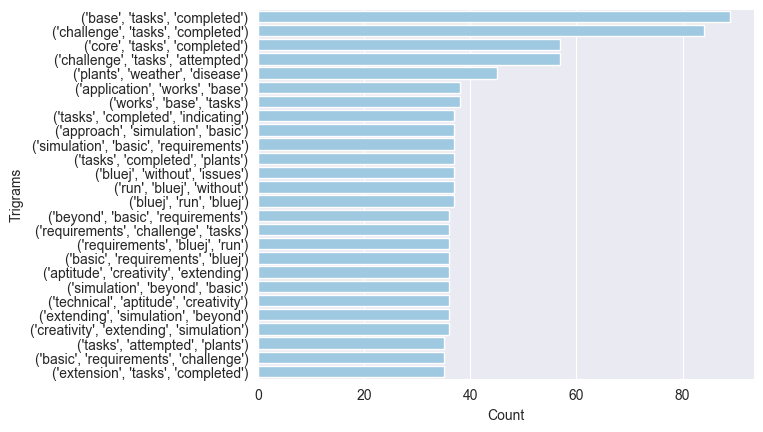

In [11]:
expl_df = nlp_df[nlp_df['skill'] == 'Correctness']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 35], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams')
g.get_figure().savefig('plots/correctness_trigrams.pdf', bbox_inches='tight')

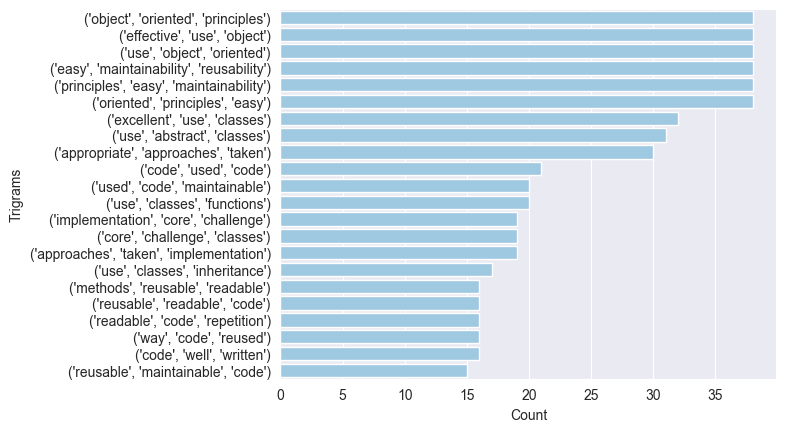

In [12]:
expl_df = nlp_df[nlp_df['skill'] == 'Code Elegance']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 15], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams')
g.get_figure().savefig('plots/code_elegance_trigrams.pdf', bbox_inches='tight')

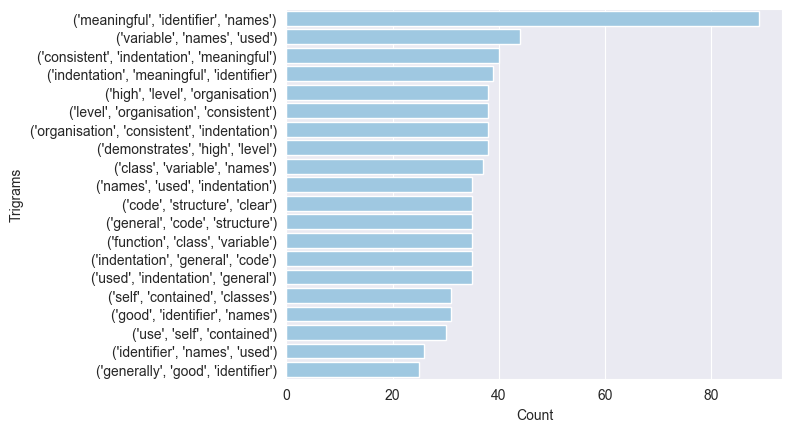

In [13]:
expl_df = nlp_df[nlp_df['skill'] == 'Readability']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 25], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams')
g.get_figure().savefig('plots/readability_trigrams.pdf', bbox_inches='tight')

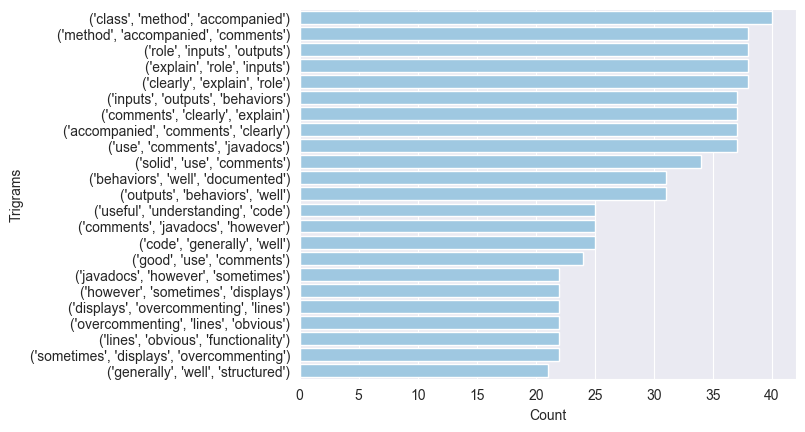

In [14]:
expl_df = nlp_df[nlp_df['skill'] == 'Documentation']['trigrams'].explode().value_counts().reset_index()
expl_df['trigrams'] = expl_df['trigrams'].astype(str)
g = sns.barplot(expl_df[expl_df['count'] >= 20], y='trigrams', x='count', color=blue)
g.set(xlabel='Count', ylabel='Trigrams')
g.get_figure().savefig('plots/documentation_trigrams.pdf', bbox_inches='tight')

### Sentiment

In [15]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,bigrams,trigrams,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...","[(code, use), (use, meaningful), (meaningful, ...","[(code, use, meaningful), (use, meaningful, id...",True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, lo...",True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, co...",True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True
...,...,...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...","[(implementation, good), (good, distinguishabl...","[(implementation, good, distinguishable), (goo...",False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]","[(compiling, specific), (specific, musicplayer...","[(compiling, specific, musicplayer), (specific...",False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...","[(comments, redundant), (redundant, state), (s...","[(comments, redundant, state), (redundant, sta...",True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...","[(methods, lack), (lack, detailed), (detailed,...","[(methods, lack, detailed), (lack, detailed, c...",True


In [16]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


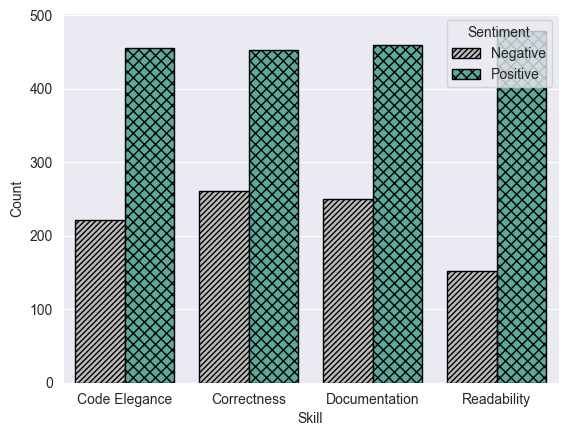

In [17]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('plots/sentiment.pdf', bbox_inches='tight')

### Topic Modelling

In [18]:
# Adapted from: https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

nlp_df['lemmas'] = nlp_df['tokens'].apply(lambda x: [get_lemma(w) for w in x])
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,tokens,bigrams,trigrams,sentiment,lemmas
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,"[code, use, meaningful, identifier, names, org...","[(code, use), (use, meaningful), (meaningful, ...","[(code, use, meaningful), (use, meaningful, id...",True,"[code, use, meaningful, identifier, names, org..."
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,"[code, well, organized, logical, classes, meth...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, lo...",True,"[code, well, organize, logical, class, method,..."
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,"[code, well, organized, consistently, indented...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, co...",True,"[code, well, organize, consistently, indent, u..."
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True,"[code, well, organize, readable, indentation, ..."
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,"[code, well, organized, readable, indentation,...","[(code, well), (well, organized), (organized, ...","[(code, well, organized), (well, organized, re...",True,"[code, well, organize, readable, indentation, ..."
...,...,...,...,...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,"[implementation, good, distinguishable, differ...","[(implementation, good), (good, distinguishabl...","[(implementation, good, distinguishable), (goo...",False,"[implementation, good, distinguishable, differ..."
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,"[compiling, specific, musicplayer, java]","[(compiling, specific), (specific, musicplayer...","[(compiling, specific, musicplayer), (specific...",False,"[compiling, specific, musicplayer, java]"
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,"[comments, redundant, state, obvious, use, sha...","[(comments, redundant), (redundant, state), (s...","[(comments, redundant, state), (redundant, sta...",True,"[comment, redundant, state, obvious, use, shar..."
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,"[methods, lack, detailed, comments, making, le...","[(methods, lack), (lack, detailed), (detailed,...","[(methods, lack, detailed), (lack, detailed, c...",True,"[method, lack, detail, comment, making, le, cl..."


In [79]:
dictionary = corpora.Dictionary(nlp_df['lemmas'])
dictionary.save('lda_data/dictionary.gensim')

def get_lda(skill):
    corpus = [dictionary.doc2bow(text) for text in nlp_df[nlp_df['skill'] == skill]['lemmas']]
    pickle.dump(corpus, open('lda_data/corpus.pkl', 'wb'))

    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save(f'lda_data/{skill}_model5.gensim')
    
    return corpus, ldamodel

In [80]:
NUM_TOPICS = 5

corpus, ldamodel = get_lda('Documentation')

topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.103*"comment" + 0.058*"documentation" + 0.044*"code" + 0.038*"explain"')
(1, '0.072*"comment" + 0.067*"method" + 0.035*"class" + 0.029*"use"')
(2, '0.046*"file" + 0.041*"number" + 0.038*"student" + 0.032*"perfect"')
(3, '0.045*"code" + 0.044*"task" + 0.034*"well" + 0.025*"readability"')
(4, '0.042*"provide" + 0.034*"accomplish" + 0.032*"suggest" + 0.031*"task"')


In [81]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.183056 -0.022694       1        1  41.290103
1     -0.189901  0.011054       2        1  31.678454
3      0.130263 -0.082938       3        1  10.702270
4      0.130569 -0.100635       4        1  10.306836
2      0.112125  0.195214       5        1   6.022337, topic_info=           Term        Freq       Total Category  logprob  loglift
23       method  186.000000  186.000000  Default  30.0000  30.0000
152        task   50.000000   50.000000  Default  29.0000  29.0000
42         good  123.000000  123.000000  Default  28.0000  28.0000
95         file   43.000000   43.000000  Default  27.0000  27.0000
145     provide   48.000000   48.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
27     variable    1.181471   16.158585   Topic5  -5.7874   0.1940
28         well    1.774945  178.966752   Topic5  -5.3804  -1.8037
69      comment    1.524501  450.093211   Topic5  -5.5325  -2.8781
489  submission    0.960901   13.556350   Topic5  -5.9941   0.1630
384    function    0.982108   80.731842   Topic5  -5.9723  -1.5995

[285 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1341      2  0.971356  accessible
432       1  0.976459   accompany
538       3  0.206571  accomplish
538       4  0.791855  accomplish
1087      1  0.329163    accurate
...     ...       ...         ...
28        4  0.061464        well
28        5  0.011175        well
658       5  0.754061      whilst
176       4  0.912925        wolf
450       2  0.960001       would

[338 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 5, 3])

# Consistency
## Individual graders

In [ ]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [ ]:
intra_rater_df = feedback_df[feedback_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'comments']]
intra_rater_df


### Length of comments

In [ ]:
intra_rater_df['length'] = intra_rater_df['comments'].str.len()
intra_rater_df['length'] = intra_rater_df['length'].fillna(0)
intra_rater_df

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Correctness')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch', loc='upper left')
dist_plt.get_figure().savefig('plots/feedback_correctness_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/feedback_code_elegance_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Readability')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch', loc='upper left')
dist_plt.get_figure().savefig('plots/feedback_readability_distance.pdf', bbox_inches='tight')

In [ ]:
dist_plt = sns.scatterplot(intra_rater_df[(intra_rater_df['skill'] == 'Documentation')], x='participant_id', y='length', style='batch', color=blue, markers=['v', '^'])

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    length_1 = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['length']

    length_2 = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['length']

    line = dist_plt.plot([participant_id, participant_id], [length_1, length_2])
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Length of Comment', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
dist_plt.get_figure().savefig('plots/feedback_documentation_distance.pdf', bbox_inches='tight')